# Fairness Benchmark

This notebook plots the suboptimality performance of various optimization algorithms against demographic/statistical parity on the Diabetes 130-Hospitals (`diabetes`) and Adult Census (`acsincome`) benchmarks.

In [168]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import binary_cross_entropy_with_logits
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")
from src.utils.io import get_path, var_to_str, load_results
from src.utils.data import load_dataset

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio
from tqdm import tqdm

In [169]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams["axes.labelsize"] = 34
mpl.rcParams['legend.fontsize'] = 32
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [170]:
l2_reg = 1.0
shift_cost = 1.0
result_dir = "../results"
base_dir = "/home/hp/pai/check1/prospect/experiments/results_4.000000_512/"

In [171]:
plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
        "epsilon":4,
        "batch_size":512,
    },
    {
        "optimizer": "dp_sgd",
        "label": "DP-SGD",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "^",
        "epsilon":4,
        "batch_size":512,
    },
    # {
    #     "optimizer": "saddlesaga",
    #     "label": "SaddleSAGA",
    #     "color": "goldenrod",
    #     "linestyle": "solid",
    #     "marker": "s",
    # },
    # {
    #     "optimizer": "lsvrg",
    #     "label": "LSVRG",
    #     "color": "cadetblue",
    #     "linestyle": "solid",
    #     "marker": "o",
    #     "epsilon":4,
    #     "batch_size":512,
    # },
    # {
    #     "optimizer": "prospect",
    #     "label": "Prospect (Ours)",
    #     "color": "tab:red",
    #     "linestyle": "solid",
    #     "marker": "^",
    # },
]

In [172]:
epsilon = 4
batch_size = 512

In [173]:
def get_mypath(base_dir,model_cfg,datset,specific_cfg):
    path1 = get_path([datset,var_to_str(model_cfg),var_to_str(specific_cfg)],base_dir)
    return path1

def get_mypath2(base_dir,model_cfg,datset):
    path1 = get_path([datset,var_to_str(model_cfg)],base_dir)
    return path1


In [174]:
def get_suboptimality(
    dataset, model_cfg, train_loss, eps=1e-9, out_path="../results/"
):
    init_loss = train_loss[0]
    path = get_path([dataset, var_to_str(model_cfg)], out_path=out_path)
    f = os.path.join(path, "lbfgs_min_loss.p")
    min_loss = pickle.load(open(f, "rb"))
    subopt = (train_loss - min_loss + eps) / (init_loss - min_loss)
    return subopt

# def get_iterates(dataset, objective, optimizer, seed=1):
  
#     loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
#     model_cfg = {
#         "objective": objective,
#         "l2_reg": l2_reg,
#         "loss": loss,
#         "n_class": None,
#         "shift_cost": shift_cost
#     }

#     path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
#     f = os.path.join(path, f"best_traj.p")
#     iterates = pickle.load(open(f, "rb"))
#     print("loading ",iterates,"type",type(iterates))
    
#     return [iterate.detach() if hasattr(iterate, 'detach') else iterate for iterate in iterates]
    
    # return [iterate.detach() for iterate in pickle.load(open(f, "rb"))]
    
def get_iterates(dataset,objective  ,optimizer, seed=1, result_dir=None):
    loss = "squared_error" if dataset == "acsincome" else "binary_cross_entropy"
    model_cfg = {
        "objective": objective,
        "l2_reg": l2_reg,
        "loss": loss,
        # "n_class": None,
        "shift_cost": shift_cost
    }
    best_path = get_mypath2(result_dir,model_cfg=model_cfg,datset=dataset)
    best_path = os.path.join(best_path,optimizer+"/best_cfg.p")
    specific_cfg = None
    # print("best_path",best_path)
    with open(best_path, 'rb') as file:
        specific_cfg = pickle.load(file)
    print("objective",objective,"specific_cfg",specific_cfg)
    
    path = get_mypath(datset=dataset,model_cfg=model_cfg,base_dir=result_dir,specific_cfg=specific_cfg)
    # print("path1",path)
    # path = get_path([dataset, var_to_str(model_cfg), optimizer], out_path=result_dir)
    f = os.path.join(path, f"seed_{seed}.p")
    data = pickle.load(open(f, "rb"))
    metrics_data = data['metrics']
    # print(metrics_data)
    # print(metrics_data['weights'].shape)
    
    return metrics_data['weights']
    # return [iterate.detach() for iterate in ]

def get_dp(X,y,dataset,column, objective,optimizer, metric="difference",df=None):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    # print("iterates",iterates)
    # print("type iterates",type(iterates),"shape",iterates.shape)
    out = []
    for i, w in tqdm(enumerate(iterates)):
        # print(X.shape)
        # print(w.shape)
        # print(X)
        # print(w)
        # w_tensor = torch.tensor(w) if isinstance(w, str) else w
        # print("i",i)
        # print("type(i)",type(i))
        # print("w",w)
        # print("type(w)",type(w))
        # # break
        # if isinstance(w,str):
        #     w = np.fromstring(w,sep=' ')
        # w_tensor = torch.tensor(w)
        # if w_tensor.dim() == 1:
        #     w_tensor = w_tensor.unsqueeze(1)
        w_tensor = w
        # print(type(w_tensor))
        # print(w_tensor.shape)
        y_pred = (X @ w_tensor >= 0).int()

        if metric == "difference":
            out.append(demographic_parity_difference(y, y_pred, sensitive_features=list(df[column])))
        elif metric == "ratio":
            out.append(demographic_parity_ratio(y, y_pred, sensitive_features=list(df[column])))
    return out

def get_ks_dist(y_pred, y_true):
    out = ks_2samp(y_pred, y_true, method="asymp")
    return out.statistic

def get_dist_groups(df,column, optimizer, objective, dataset="acsincome", method="ks"):
    iterates = get_iterates(dataset=dataset,objective=objective, optimizer=optimizer,result_dir=base_dir)
    print(iterates)
    print()
    # return
    groups = list(df[column].unique())

    dist_groups = []

    for i, w in tqdm(enumerate(iterates)):
        y_pred = (X @ w).numpy()
        ypd = pd.Series(y_pred)
        y_groups = [(ypd.loc[df[column] == group]).to_numpy() for group in groups]
        if method == "ks":
            dist_groups.append(np.array([get_ks_dist(y_pred, y_group) for y_group in y_groups]))
        elif method == "wasserstein":
            raise Exception("Wasserstein not defined!")
        #     dist_groups.append(np.array([wasserstein_dist(y_pred, y_group) for y_group in y_groups]))

    return np.array(dist_groups)

def plot_ax(ax, seeds, objective, plot_cfg, dataset, epoch_len=None, n=4000, downsample=1, max_epoch=32, markersize=8, out_path="../results/"):
    optimizer = plot_cfg['optimizer']
    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": "binary_cross_entropy" if dataset == "diabetes" else "squared_error", 
        "n_class": None,
        "shift_cost": shift_cost
    }
    for seed in seeds:
        filename = plot_cfg["optimizer"]
        path = get_path([dataset, var_to_str(model_cfg), filename], out_path=out_path)
        df = pickle.load(open(os.path.join(path, "best_traj.p"), "rb"))
        train_loss = torch.tensor(df["average_train_loss"])
        epochs = torch.arange(len(train_loss))
        subopt = get_suboptimality(
            dataset, model_cfg, train_loss, out_path=result_dir
        )
        if optimizer == "lsvrg":
            x = epochs * 2
        elif optimizer in ["sgd", "srda"]:
            x = epochs
        else:
            x = epochs
        idx = (x <= max_epoch)
        ax.plot(
            x[idx][::downsample], 
            subopt[idx][::downsample], 
            label=plot_cfg['label'], 
            color=plot_cfg['color'],
            marker=plot_cfg['marker'],
            markersize=markersize
        )

objective superquantile specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:04, 27.88it/s]


sp mean sgd 0.03222155710273951
sp std sgd 0.0037560400345592318
objective superquantile specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.1, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:05, 25.43it/s]


sp mean dp_sgd 0.04635271241528095
sp std dp_sgd 0.01603700839341622
objective esrm specific_cfg {'optimizer': 'sgd', 'lr': 0.003, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:04, 28.23it/s]


sp mean sgd 0.03222155710273951
sp std sgd 0.0037560400345592318
objective esrm specific_cfg {'optimizer': 'dp_sgd', 'lr': 0.01, 'epoch_len': None, 'shift_cost': 1.0, 'batch_size': 512, 'dataset_length': 4000, 'noise': 4.27754669227007}


129it [00:03, 38.69it/s]


sp mean dp_sgd 0.03197126683834784
sp std dp_sgd 0.01775579276248545


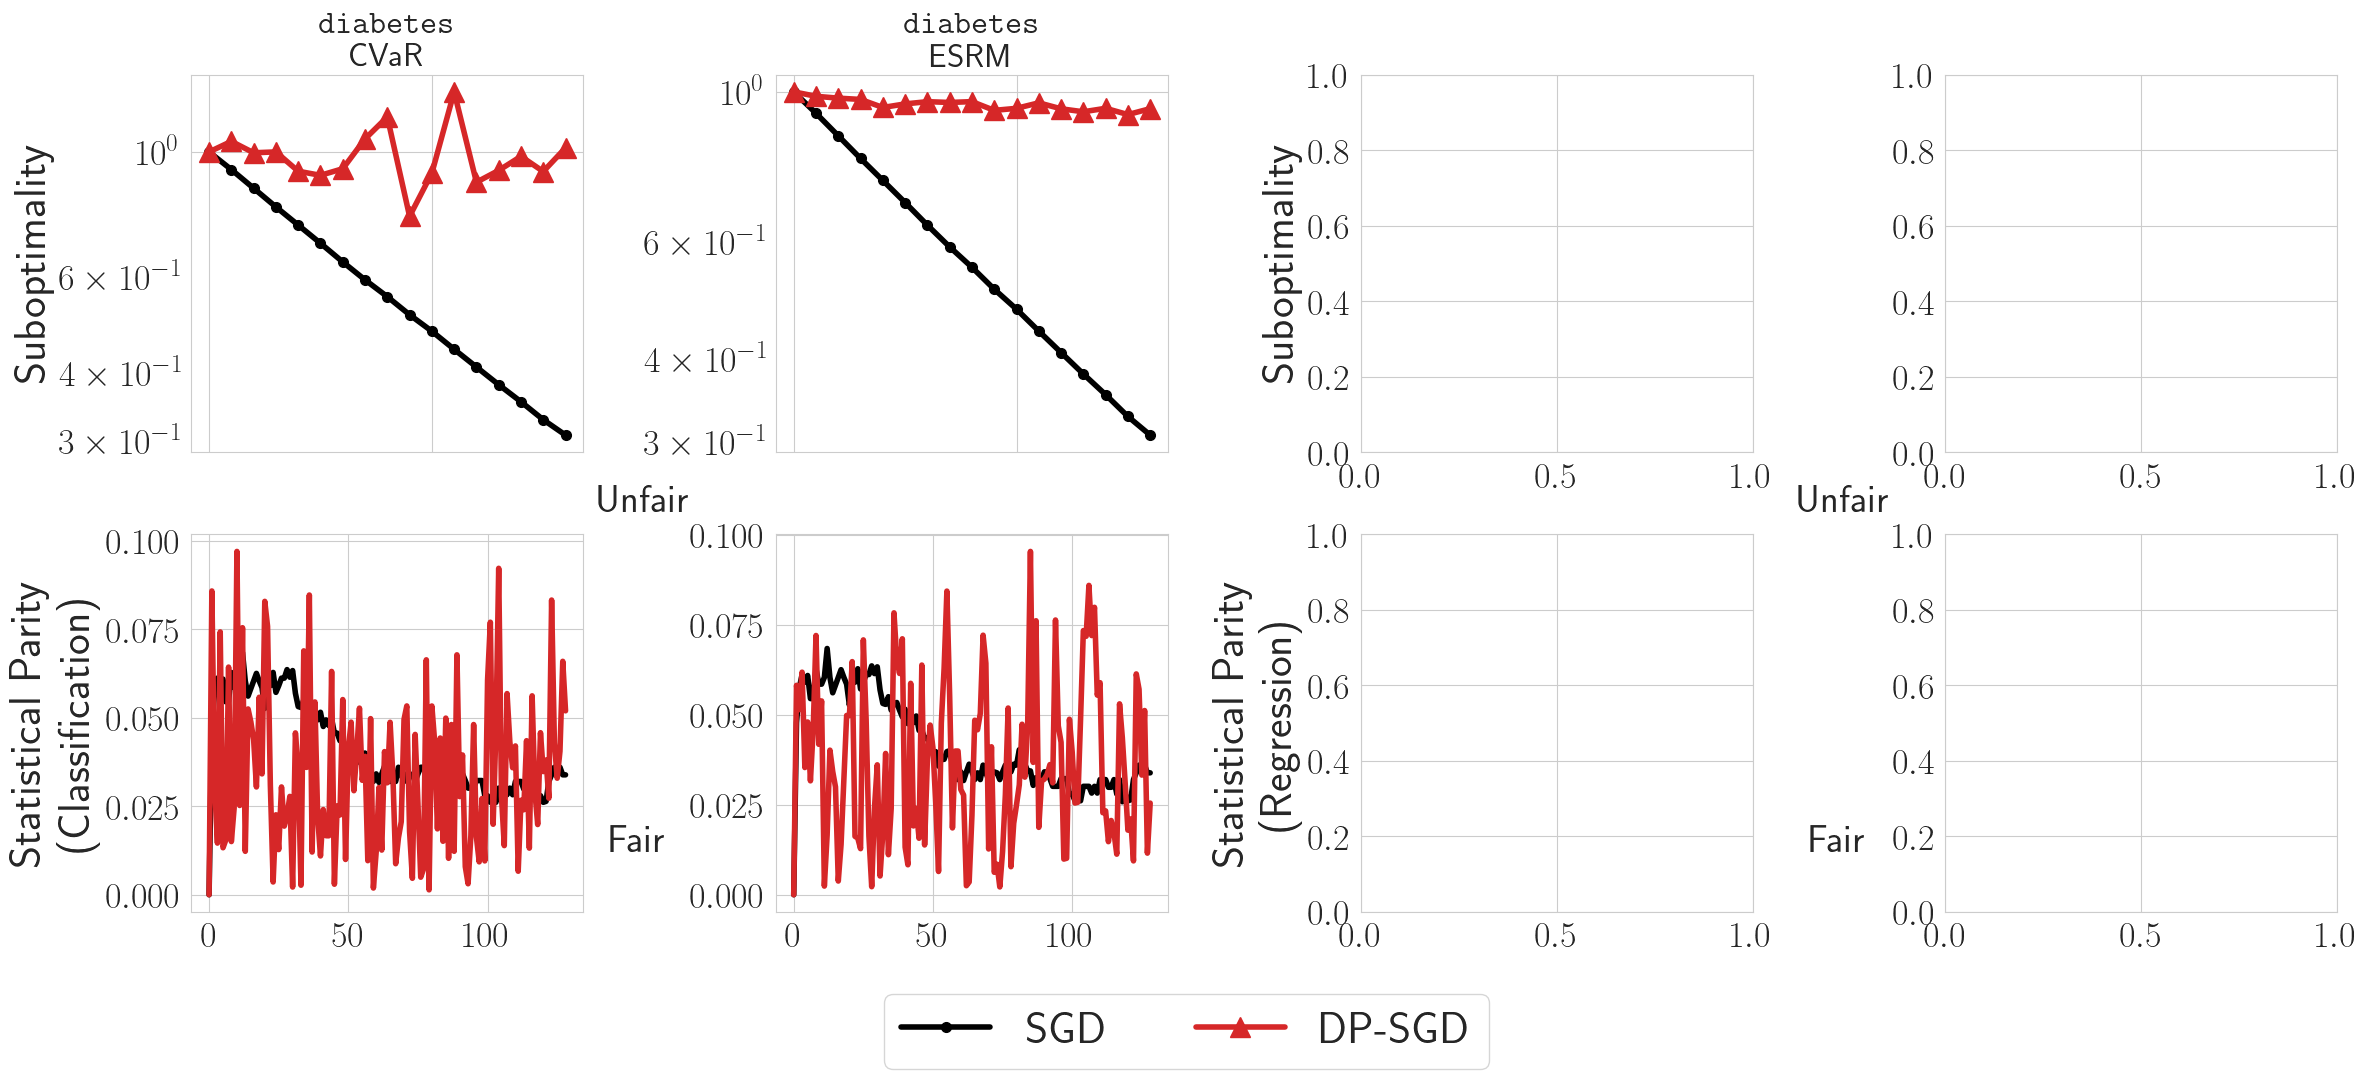

In [175]:
## demographic parity
from sklearn.preprocessing import LabelEncoder
dataset = "diabetes"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.gender.unique())
# print(df.race.unique())
# print(df.head)
# sex_tensor = torch.tensor(pd.get_dummies(df["gender"]).values, dtype=torch.float64)
# rac1p_tensor = torch.tensor(pd.get_dummies(df["race"]).values, dtype=torch.float64)

le_gender = LabelEncoder()
le_race = LabelEncoder()

gender_encoded = le_gender.fit_transform(df["gender"])
race_encoded = le_race.fit_transform(df["race"])

# Convert to tensors
gender_tensor = torch.tensor(gender_encoded, dtype=torch.float64).unsqueeze(1)
race_tensor = torch.tensor(race_encoded, dtype=torch.float64).unsqueeze(1)

# Concatenate the new attributes to X
X1 = torch.cat((X, gender_tensor, race_tensor), dim=1)

objectives = ["superquantile", "esrm"]
column = "gender"
metric = "difference"

sns.set_style("whitegrid")

fig, ax = plt.subplots(2, len(objectives) * 2, figsize=(12 * len(objectives), 10))

obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
for j, objective in enumerate(objectives):
    for plot_cfg in plot_cfgs:
        optimizer = plot_cfg["optimizer"]
        yy = get_dp(X=X,y=y,dataset=dataset,column=column,objective=objective, optimizer=optimizer, metric=metric,df=df)
        xx = np.arange(len(yy))

        print(f"sp mean {optimizer}", np.array(yy)[-10:].mean())
        print(f"sp std {optimizer}", np.array(yy)[-10:].std())

        markersize = 14
        downsample = 2
        ax[1, j].plot(xx, yy, label=plot_cfg['label'], color=plot_cfg['color'])
        # ax[1, j].set_xticklabels([])
        ax[0, j].set_title(r"{\texttt{diabetes}}" + f"\n{obj_names[j]}", fontsize=24)

        plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=32, downsample=downsample, markersize=markersize,out_path=base_dir)
        ax[0, j].set_yscale("log")
        ax[0, j].set_xticklabels([])

ax[1, 0].set_ylabel("Statistical Parity\n(Classification)", fontsize=32)
ax[0, 0].set_ylabel(f"Suboptimality", fontsize=32)

# acsincome

dataset = "acsincome"

X = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/X_test.npy"))
y = torch.tensor(np.load(f"/home/hp/pai/test/prospect/data/{dataset}/y_test.npy")).double()

# print(X.shape)
# print(y.shape)

df = pd.read_csv(f"../data/{dataset}/metadata_te.csv")
# print(df.SEX.unique())
# print(df.RAC1P.unique())

objectives = ["superquantile", "esrm", "superquantile", "esrm"]
column = "RAC1P"
# metric = "ratio"
# dataset = "acsincome"

# obj_names = ["CVaR", "ESRM", "CVaR", "ESRM"]
# for j, objective in enumerate(objectives):
#     if j > 1:
#         for plot_cfg in plot_cfgs:
#             optimizer = plot_cfg["optimizer"]
#             group_loss = get_dist_groups(df,column, optimizer, objective)
#             yy = np.max(group_loss, axis=1) # worst distance
#             xx = np.arange(len(yy))

#             markersize = 14
#             downsample = 6
#             ax[1, j].plot(xx, yy, label=plot_cfg['label'], color=plot_cfg['color'])
#             ax[1, j].set_xticklabels([])
#             ax[0, j].set_title(r"{\texttt{acsincome}}" + f"\n{obj_names[j]}", fontsize=24)

#             plot_ax(ax[0, j], [1], objective, plot_cfg, dataset, max_epoch=64, downsample=downsample, markersize=markersize)
#             ax[0, j].set_yscale("log")
#             ax[0, j].set_xticklabels([])


# # arrows
fig.text(0.26, 0.13, "Fair", fontsize=28)
fig.text(0.255, 0.47, "Unfair", fontsize=28)
fig.text(0.76, 0.13, "Fair", fontsize=28)
fig.text(0.755, 0.47, "Unfair", fontsize=28)

ax[1, 2].set_ylabel("Statistical Parity\n(Regression)", fontsize=32)
ax[0, 2].set_ylabel(f"Suboptimality", fontsize=32)
plt.tight_layout(pad=2.0)
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
            bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.savefig(f"../figures/fairness_training_curves.pdf", bbox_inches="tight")
plt.show()